In [40]:
import sys
sys.path.append('..')
import os
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import torch

from models.ddpg import DDPG
from models.model import OUNoise
from env.AlphaEnv import AlphaEnv
import gymnasium as gym

## 1. 准备数据

In [2]:
# 读取股票池文件
df_pool = pd.read_csv('../data/股票池和因子/股票池/IDX_000905.SH.csv')
df_pool['TRADE_DATE'] = pd.to_datetime(df_pool['TRADE_DATE'], format='%Y%m%d').dt.date
df_pool['STOCK_CODE'] = df_pool['STOCK_CODE'].astype(str)
df_pool['STOCK_CODE'] = df_pool['STOCK_CODE'].apply(lambda x: x.zfill(6))

# 读取因子文件
df_alpha = pd.read_csv('../data/股票池和因子/因子/Alpha_1.csv')
df_alpha['TRADE_DATE'] = pd.to_datetime(df_alpha['TRADE_DATE'], format='%Y%m%d').dt.date
df_alpha['STOCK_CODE'] = df_alpha['STOCK_CODE'].astype(str)
df_alpha['STOCK_CODE'] = df_alpha['STOCK_CODE'].apply(lambda x: x.zfill(6))

# 读取宏观因子文件
df_macro = pd.read_csv('../data/processed/macro_data.csv')
df_macro['date'] = pd.to_datetime(df_macro['date'], format='%Y-%m-%d').dt.date
df_macro = df_macro.rename(columns={'date': 'TRADE_DATE'})

# 公共交易日
dates = list(set(df_pool['TRADE_DATE']) & set(df_alpha['TRADE_DATE']) & set(df_macro['TRADE_DATE']))
df_alpha = df_alpha[df_alpha['TRADE_DATE'].isin(dates)].sort_values(['TRADE_DATE', 'STOCK_CODE']).reset_index(drop=True)
df_macro = df_macro[df_macro['TRADE_DATE'].isin(dates)].sort_values(['TRADE_DATE']).reset_index(drop=True)
df_pool = df_pool[df_pool['TRADE_DATE'].isin(dates)][['TRADE_DATE', 'STOCK_CODE']].sort_values(['TRADE_DATE', 'STOCK_CODE']).reset_index(drop=True)

# 提取股票池中的股票数据，内连接
df_alpha = df_pool[['TRADE_DATE', 'STOCK_CODE']].merge(df_alpha, how='inner', on=['TRADE_DATE', 'STOCK_CODE'])

df_alpha

,TRADE_DATE,STOCK_CODE,ALPHA
0,2018-01-02,000006,0.005345
1,2018-01-02,000009,0.008090
2,2018-01-02,000012,-0.001299
3,2018-01-02,000021,0.000561
4,2018-01-02,000025,-0.004755
...,...,...,...
353414,2020-12-31,688002,0.014913
353415,2020-12-31,688029,0.003583
353416,2020-12-31,688088,0.000285
353417,2020-12-31,688099,0.007040


In [3]:
# 读取股票量价数据
codes = df_alpha['STOCK_CODE'].unique()
code_files = [x for x in os.listdir('../data/股票池和因子/量价') if x[:6] in codes]
stock_list = []
for file in tqdm(code_files):
    df_tmp = pd.read_csv('../data/股票池和因子/量价/' + file, encoding='gbk')
    df_tmp['TRADE_DATE'] = pd.to_datetime(df_tmp['日期'], format='%Y-%m-%d').dt.date
    df_tmp['STOCK_CODE'] = df_tmp['代码'].apply(lambda x: x[:6])
    # df_tmp['RETURN'] = (df_tmp['收盘价(元)'] / df_tmp['开盘价(元)'] - 1) / 100  # 定义可实现的收益率
    df_tmp['RETURN'] = df_tmp['涨跌幅(%)'] / 100
    df_tmp = df_tmp[['TRADE_DATE', 'STOCK_CODE', 'RETURN']]
    stock_list.append(df_tmp)

df_stock = pd.concat(stock_list)

100%|██████████| 750/750 [00:20<00:00, 36.50it/s]


In [4]:
# 对齐
df_keys = df_stock[['TRADE_DATE', 'STOCK_CODE']].merge(df_alpha[['TRADE_DATE', 'STOCK_CODE']]).merge(df_macro[['TRADE_DATE']])
df_keys = df_keys.sort_values(['TRADE_DATE', 'STOCK_CODE']).reset_index(drop=True)

df_alpha = df_keys.merge(df_alpha, how='left', on=['TRADE_DATE', 'STOCK_CODE'])
df_stock = df_keys.merge(df_stock, how='left', on=['TRADE_DATE', 'STOCK_CODE'])
df_macro = df_macro[df_macro['TRADE_DATE'].isin(df_keys['TRADE_DATE'])]

当前数据结构
- 因子数据：日期-代码-因子值
- 量价数据：日期-代码-收益率
- 宏观数据：日期-宏观1-...-宏观N

In [5]:
def check(df_stock, df_alpha):
    '''
    对齐，使得
    当前交易日的因子维度 = 下一交易日收益率维度
    '''
    assert len(df_stock) == len(df_alpha)
    col_date, col_code, col_return = df_stock.columns
    dates = df_alpha[col_date].unique()
    df_stock_list, df_alpha_list = [], []
    for i in tqdm(range(len(dates) - 1)):
        date_now = dates[i]
        date_next = dates[i+1]
        df_alpha_now = df_alpha[df_alpha[col_date] == date_now]
        df_stock_next = df_stock[df_stock[col_date] == date_next]
        codes_common = list(set(df_alpha_now[col_code]) & set(df_stock_next[col_code]))  # 公共的股票
        df_alpha_now = df_alpha_now[df_alpha_now[col_code].isin(codes_common)]
        df_stock_next = df_stock_next[df_stock_next[col_code].isin(codes_common)]
        df_stock_list.append(df_stock_next)
        df_alpha_list.append(df_alpha_now)
    df_stock = pd.concat(df_stock_list).sort_values([col_date, col_code]).reset_index(drop=True)
    df_alpha = pd.concat(df_alpha_list).sort_values([col_date, col_code]).reset_index(drop=True)
    return df_stock, df_alpha

In [6]:
# 划分训练集与测试集
train_size = int(len(df_stock) * 0.8)
train_date_end = df_stock['TRADE_DATE'][train_size]

df_macro_train, df_macro_test = df_macro[df_macro['TRADE_DATE'] <= train_date_end], df_macro[df_macro['TRADE_DATE'] > train_date_end]
df_stock_train, df_stock_test = df_stock[df_stock['TRADE_DATE'] <= train_date_end], df_stock[df_stock['TRADE_DATE'] > train_date_end]
df_alpha_train, df_alpha_test = df_alpha[df_alpha['TRADE_DATE'] <= train_date_end], df_alpha[df_alpha['TRADE_DATE'] > train_date_end]

df_stock_train, df_alpha_train = check(df_stock_train, df_alpha_train)
df_stock_test, df_alpha_test = check(df_stock_test, df_alpha_test)

100%|██████████| 138/138 [00:11<00:00, 11.94it/s]


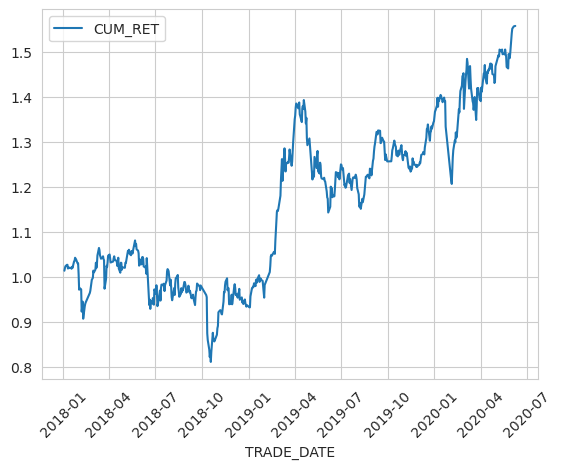

In [7]:
# 基准组合表现，手动设定action
# action = [scale, threshold]
env = AlphaEnv(df_macro=df_macro_train, df_alpha=df_alpha_train, df_stock=df_stock_train)
returns_test = env.predict(df_stock=df_stock_train, df_alpha=df_alpha_train, action = [1, 0.001])

df_return_test = pd.DataFrame(data={'TRADE_DATE': returns_test.keys(), 'RETURN': returns_test.values()})
df_return_test = df_return_test.sort_values('TRADE_DATE')
df_return_test['CUM_RET'] = (1 + df_return_test['RETURN']).cumprod()
df_return_test
df_return_test.plot(x='TRADE_DATE', y='CUM_RET', rot=45)

plt.show()

## 2. 训练

In [45]:
class AlphaEnv(gym.Env):
    """A custom stock trading environment based on OpenAI gymnasium"""
    metadata = {'render.modes': ['human']}

    def __init__(self, 
                 df_macro,
                 df_stock,
                 df_alpha,
                 num_actions=2,
                 look_forward=1,
                 fee_ratio=2e-4,
                 trade_pct=0.5   #交易比例，取值范围(0,1]
        ):
        '''
        - df_macro:
        - df_stock:
        - df_alpha:
        - look_forward: define reward as the return of the future look_forward days
        - fee_ratio: bid fee ratio
        '''
        super(AlphaEnv, self).__init__()
        
        assert 1 == 1  # 验证三个df日期和代码是否对齐

        # print('Initialize trade environment...')
        # print('Aligning df_macro, df_stock and df_alpha...')

        # self.dates = list(set(df_macro['date']) & set(df_alpha['date']) & set(df_stock['date']))
        # self.cols = list(set(df_alpha.columns) & set(df_stock.columns))
        # self.df_macro = df_macro.loc[df_macro['date'].isin(self.dates)].set_index('date').values
        # self.data_alpha = df_alpha.loc[df_alpha['date'].isin(self.dates), self.cols].set_index('date').values
        # self.df_stock = df_stock.loc[df_stock['date'].isin(self.dates), self.cols].set_index('date').values

        self.df_macro = df_macro
        self.df_stock = df_stock
        self.df_alpha = df_alpha

        self.num_periods, self.num_stocks = self.df_stock.shape
        self.num_macros = self.df_macro.shape[1] - 1
        self.num_actions = num_actions

        # print('df_macro shape: ', self.df_macro.shape)
        # print('df_stock shape: ', self.df_stock.shape)
        # print('df_alpha shape: ', self.data_alpha.shape)

        self.col_date, self.col_code, self.col_alpha = df_alpha.columns  # 提取列名
        self.col_return = df_stock.columns[-1]  # df_stock最后一列为收益率
        self.col_macro = df_macro.columns[1:]  # df_macro第一列到最后一列都是因子值

        self.look_forward = look_forward
        self.fee_ratio = fee_ratio
        self.trade_pct = trade_pct

        # self.current_idx = 0
        self.max_idx = len(self.df_macro)-1
        # self.terminated  = False

    # weight_alpha：模型权重w_a，是关于alpha的单调函数，且L1范数为1
    def weight_alpha(self, alpha, action):
        alpha = np.array(alpha)
        scale, threshold = action[0], action[1]
        # w = np.tanh(np.maximum(np.array(alpha) - threshold, 0) + threshold) ** scale
        # w[w < np.tanh(threshold * scale)] = 0
        # w /= np.sum(w)
        w = np.sign(alpha) * np.abs(alpha) ** scale
        w[w < threshold] = 0
        # w[np.nonzero(w)[0]] = w[np.nonzero(w)[0]] ** scale
        # w = np.sign(w) * np.abs(w) ** scale
        # w[w <= np.tanh(threshold) * scale] = 0
        if np.sum(w) == 0:
            w = np.ones_like(w) / len(w)
        else:
            w /= np.sum(w)
        return w
    
    # weight_target: 目标权重w_t，是w_0与w_a的加权平均,同时产生交易权重w_delta
    def weight_target(self, w_0, w_a):
        l = self.trade_pct
        w = l * w_a + (1-l) * w_0
        w_delta = l * np.abs(w_a - w_0)
        return w, w_delta
    
    # weight_end：结算权重w_end，w_t经过日内收益变化，再减去交易费用，最后归一化
    def weight_end(self, r, w_t, w_delta):
        fee = np.sum(self.fee_ratio * w_delta)
        #收盘时，权重由于股票的日内收益已经产生变化，同时收盘前要按市值等比例卖出还交易费用
        w_end = (1 + r) * w_t
        w_sum_end = np.sum(w_end)
        r_end = w_sum_end - fee - 1
        #等比例减仓
        w = w_end * (1 + r_end) / w_sum_end
        #归一化
        w /= np.sum(w)
        return w, r_end, fee

    
    # important
    def step(self, action):
        if self.current_idx + self.look_forward + 1 > self.max_idx:
            self.current_idx = 0
            self.terminated  = True
            return None, None, True
        else:
            #reward计算
            #1.获得t日数据，每股的alpha和收益率（r）
            #2.获得模型权重w_a，根据action和alpha计算
            #3.获得目标权重w_t，根据超参数-调参比例l和w_a及t日起始权重w_start计算
            #4.获得结算权重w_end，同时获得reward和交易费用fee
            #5.更新t+1日起始权重w_start（就是t日的w_end）
            alpha = self.df_alpha[self.current_idx].astype(float)
            r = self.df_stock[self.current_idx + self.look_forward + 1].astype(float) / self.df_stock[self.current_idx + 1].astype(float) - 1
            w_a = self.weight_alpha(alpha, action)
            w_t, w_delta = self.weight_target(self.w_start, w_a)
            w_end, reward, fee = self.weight_end(r, w_t, w_delta)
            self.w_start = w_end
            
            #next state
            self.current_idx += 1 
            next_state = self.df_macro.iloc[self.current_idx, 1:].astype(float)
            return next_state, reward, False
    

    def predict(self,
                df_stock, 
                df_alpha, 
                action=[0, 1]):
        '''
        预测收益率，给定动作值
        '''
        returns = {}
        action = np.array(action)
        col_date, col_code, col_alpha = df_alpha.columns  # 提取列名
        col_return = df_stock.columns[-1]
        dates = df_alpha.sort_values(col_date)[col_date].unique()  # 第一列为交易日期
        for i in range(len(dates) - 1):
            date_now = dates[i]
            date_next = dates[i+1]
            alpha = df_alpha[df_alpha[col_date] == date_now][col_alpha]  # 当前交易日的因子值
            weight = self.weight_alpha(alpha, action)  # 预测的权重
            returns[date_next] = df_stock[df_stock[col_date] == date_next][col_return].values @ weight  # 预测收益率
        return returns
        


    # important
    def reset(self):
        self.current_idx = 0
        self.w_start = np.zeros(self.df_stock.shape[1])
        return self.df_macro.iloc[0, 1:].values

In [46]:
hidden_size_list = [128, 128] 
# env = Env(df_macro=df_macro_train, df_alpha=df_alpha_train, df_stock=df_stock_train)
env = AlphaEnv(df_macro=df_macro_train, df_alpha=df_alpha_train, df_stock=df_stock_train)
agent = DDPG(env=env, hidden_size_list=hidden_size_list, max_memory_size=1e5, 
                actor_learning_rate=1e-3, critic_learning_rate=1e-3)

In [52]:
batch_size = 64
rewards = []
avg_rewards = []

for episode in range(20):
    state = env.reset()
    # noise.reset()
    episode_reward = 0
    
    for i in range(1, 5000):
        action = agent.get_action(state)
        # noise = np.clip(np.random.randn(2) , -0.1, 0.05)
        # action += noise
        action[0] += np.random.randn() * 0.05
        action[1] += np.clip(np.random.randn() * 0.05, -0.05, 0.05)
        action[0] = np.clip(action[0], 0.1, 20)
        # action[1] = np.clip(action[1], 0, 1)


        next_state, reward, terminated = env.step(action) 
        if not terminated:
            agent.memory.push(state, action, reward, next_state, terminated)
        
            state = next_state
            episode_reward += reward

        if len(agent.memory) > 1e3:
            agent.update(batch_size) 
            if i % 100 == 0:
                print('{}, {:>4d}, {}, {}: {:.7f}'.format(episode, i, env.current_idx, action.round(3), episode_reward / i))

        if terminated:
            print('terminated')
            break

    rewards.append(episode_reward)
    avg_rewards.append(np.mean(rewards[-10:]))

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

array([0.9358309870227572, 0.1066246951313012, 0.2629564362940665,
       0.9252311785445936, 0.9238843034053286, -0.8567869169991,
       -0.6519282980755391, 1.3918326123242537, -0.2174762629631002,
       -0.0329234294083833, 0.1517352535307699, -0.115027051142614,
       -1.178832955919484, -0.7948916699150648, 1.163152611626043,
       0.1489159671940404, 0.353418808027814, 0.9324717397691984,
       1.063870260064903, -0.795781269130804, -0.6021578870365345,
       0.4834367963844305, -1.4452541209910117, -1.3592720033244732,
       -0.3060218626848832, -0.2295942455890367, -1.4071066252881756,
       -1.078684932753016, 1.6227458906831838, 0.0299111576311151,
       0.0765001574757896, 0.2485205354759202, 0.0506315149027152,
       -1.0262612879299062, -0.6827338370568533, 1.4577995812878977,
       -0.5867823675124235, -0.3462036519940374, -0.9087662426708338,
       -1.1953746240842729, -1.0146689395996773, -0.9099551663857436,
       1.5082404358800492, -0.5932908077706878, -

## 参考

In [ ]:
hidden_size_list = [128, 128] 
agent = DDPG(env=env, hidden_size_list=hidden_size_list, max_memory_size=1e5, 
                actor_learning_rate=1e-3, critic_learning_rate=1e-3)
# noise = OUNoise(action_dim=2)

In [ ]:
env.max_idx, train_size, env.look_forward

(2138, 2139, 1)

In [ ]:
batch_size = 64
rewards = []
avg_rewards = []

for episode in range(20):
    state = env.reset()
    # noise.reset()
    episode_reward = 0
    
    for i in range(1, 5000):
        action = agent.get_action(state)
        # noise = np.clip(np.random.randn(2) , -0.1, 0.05)
        # action += noise
        action[0] += np.random.randn() * 0.05
        action[1] += np.clip(np.random.randn() * 0.05, -0.05, 0.05)
        action[0] = np.clip(action[0], 0.1, 20)
        # action[1] = np.clip(action[1], 0, 1)


        next_state, reward, terminated = env.step(action) 
        if not terminated:
            agent.memory.push(state, action, reward, next_state, terminated)
        
            state = next_state
            episode_reward += reward

        if len(agent.memory) > 1e3:
            agent.update(batch_size) 
            if i % 100 == 0:
                print('{}, {:>4d}, {}, {}: {:.7f}'.format(episode, i, env.current_idx, action.round(3), episode_reward / i))

        if terminated:
            print('terminated')
            break

    rewards.append(episode_reward)
    avg_rewards.append(np.mean(rewards[-10:]))

0, 1100, 1100, [ 0.303 -0.021]: -0.0001455
0, 1200, 1200, [20.    0.95]: 0.0000157
0, 1300, 1300, [20.     0.835]: 0.0005102
0, 1400, 1400, [20.     1.019]: 0.0004194
0, 1500, 1500, [20.    0.95]: 0.0003813
0, 1600, 1600, [20.     0.967]: 0.0003434
0, 1700, 1700, [20.     1.026]: 0.0004364
0, 1800, 1800, [20.    1.05]: 0.0003578
0, 1900, 1900, [20.    1.05]: 0.0004667
0, 2000, 2000, [20.     0.959]: 0.0004443
0, 2100, 2100, [20.     0.963]: 0.0003770
terminated
1,  100, 100, [20.    0.95]: -0.0055335
1,  200, 200, [20.    0.95]: -0.0043209
1,  300, 300, [20.     0.968]: -0.0027802
1,  400, 400, [20.     1.034]: -0.0019139
1,  500, 500, [20.    1.05]: -0.0023388
1,  600, 600, [20.     1.033]: -0.0020954
1,  700, 700, [20.    0.95]: -0.0016534
1,  800, 800, [20.     0.987]: -0.0009316
1,  900, 900, [20.    1.05]: -0.0007251
1, 1000, 1000, [20.     0.976]: -0.0005621
1, 1100, 1100, [20.    1.05]: -0.0003016
1, 1200, 1200, [20.     0.997]: -0.0001002
1, 1300, 1300, [20.    0.95]: 0.0004033

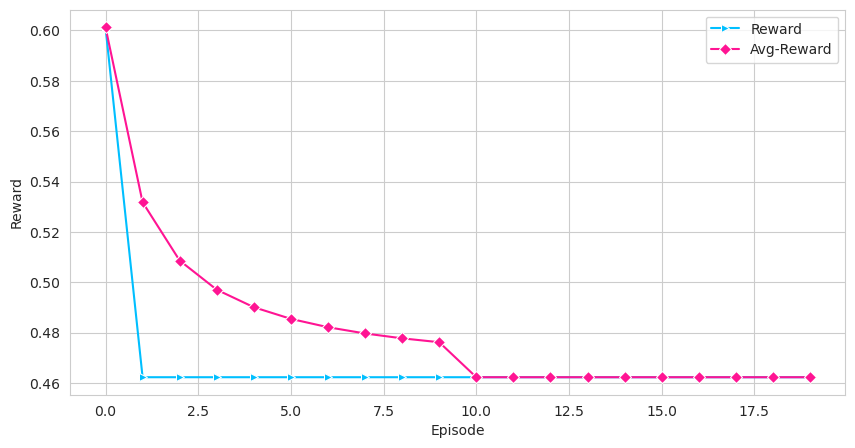

In [ ]:
fig = plt.figure(figsize=(10,5))
sns.lineplot(rewards, marker='>', color='deepskyblue', label='Reward')
sns.lineplot(avg_rewards, marker='D', color='deeppink', label='Avg-Reward')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.show()

### Out-of-sample performance

In [ ]:
dates = list(set(df_macro['date']) & set(df_factor['date']) & set(df_stock['date']))
cols = list(set(df_factor.columns) & set(df_stock.columns))
data_macro_test = df_macro_test.loc[df_macro['date'].isin(dates)].set_index('date').values
data_factor_test = df_factor_test.loc[df_factor['date'].isin(dates), cols].set_index('date').values
data_stock_test = df_stock_test.loc[df_stock['date'].isin(dates), cols].set_index('date').values

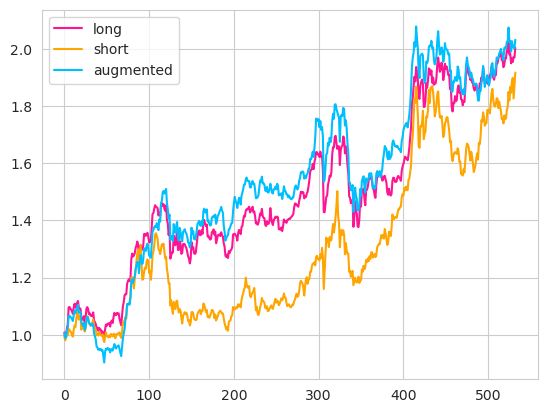

In [ ]:
weight = np.zeros(data_stock_test.shape[1])
ret_list = []
ret_long_list = []
ret_short_list = []

# for i in range(len(data_macro_test) - 2):
#     state = data_macro_test[i].astype(float)
#     factor = data_factor_test[i].astype(float)
#     action = agent.get_action(state)
#     # print(action)
#     weight_new = env._to_weight(factor, action)
#     fee = np.linalg.norm(weight_new - weight, ord=1) * env.fee_ratio
#     ret_stock = data_stock_test[i+2] / data_stock_test[i+1] - 1
#     ret_net = ret_stock @ weight_new - fee
#     ret_list.append(ret_net)
#     weight = weight_new   

for i in range(len(data_macro_test) - 2):
    state = data_macro_test[i].astype(float)
    factor = data_factor_test[i].astype(float)
    action = agent.get_action(state)
    action[0] = np.clip(action[0], 0.1, 10)
    # print(action)
    
    w_start = np.ones_like(factor) / len(factor)
    w_a = env.weight_alpha(factor, action)  # 模型权重
    w_t, w_delta = env.weight_target(w_start, w_a)
    r = data_stock_test[i+2] / data_stock_test[i+1] - 1  # 股票收益率
    w_end, reward, fee = env.weight_end(r, w_t, w_delta)
    ret_list.append(reward)
    w_start = w_end 

    # 多头因子组合
    ind_max = np.argsort(factor)[-50:]
    ret_long = r[ind_max].mean()
    ret_long_list.append(ret_long)

    # 空头因子组合
    ind_min = np.argsort(factor)[:50]
    ret_short = r[ind_min].mean()
    ret_short_list.append(ret_short)

plt.plot(np.cumprod(1 + np.array(ret_long_list)), color='deeppink', label='long')
plt.plot(np.cumprod(1 + np.array(ret_short_list)), color='orange', label='short')
plt.plot(np.cumprod(1 + np.array(ret_list)), color='deepskyblue', label='augmented')
plt.legend()
plt.show()

In [ ]:
sr_long = np.mean(ret_long_list) / np.std(ret_long_list)
sr_short = np.mean(ret_short_list) / np.std(ret_short_list)
sr_augmented = np.mean(ret_list) / np.std(ret_list)


print('SR-Long: ', sr_long.round(5))
print('SR-Short: ', sr_short.round(5))
print('SR-Augmented: ', sr_augmented.round(5))

SR-Long:  0.08931
SR-Short:  0.07709
SR-Augmented:  0.08909


## 总结
- train-test-splitting之前有问题，仅通过比例划分，会割裂一个交易日的多只股票
- 改写AlphaEnv
- 手动设置action，作为基准